# EVALUATION FINALE & PREDICTIONS - CHURN PREDICTION

### **Objectif**: Evaluer le modele final sur le test set et generer les predictions

### **Contenu**:
#### 1. Chargement du meilleur modele
#### 2. Evaluation sur le test set
#### 3. Analyse des erreurs
#### 4. Predictions finales
#### 5. Interpretation et recommandations business

## IMPORTATION DES BIBLIOTHEQUES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

import joblib
from pathlib import Path
import json

In [3]:
np.random.seed(42)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Bibliotheques importees avec succes!")

Bibliotheques importees avec succes!


## CHARGEMENT DES DONNEES ET DU MODELE

In [5]:
# Detecter le chemin de base
current_path = Path.cwd()
if current_path.name == 'notebooks':
    base_path = current_path.parent
else:
    base_path = current_path

processed_path = base_path / 'data' / 'processed'
models_path = base_path / 'models' / 'saved_models'

print("="*60)
print("CHARGEMENT DES DONNEES ET DU MODELE")
print("="*60)

CHARGEMENT DES DONNEES ET DU MODELE


In [7]:
# Charger les donnees de validation et test
X_val = pd.read_csv(processed_path / 'X_val.csv')
y_val = pd.read_csv(processed_path / 'y_val.csv')['Exited']
X_test = pd.read_csv(processed_path / 'X_test.csv')

print(f"\nValidation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Validation set: (52046, 24)
Test set: (110023, 24)


In [9]:
# Lister les modeles disponibles
available_models = list(models_path.glob('best_model_*.pkl'))

print(f"\nModeles disponibles ({len(available_models)}):")
for i, model_file in enumerate(available_models, 1):
    print(f"  {i}. {model_file.name}")

# Charger le meilleur modele
if available_models:
    best_model_path = available_models[0]
    best_model = joblib.load(best_model_path)
    model_name = best_model_path.stem.replace('best_model_', '').replace('_', ' ').title()
    print(f"\nModele charge: {model_name}")
    print(f"Chemin: {best_model_path}")
else:
    print("\nAucun modele trouve. Veuillez d'abord executer le notebook 03.")
    raise FileNotFoundError("Aucun modele sauvegarde trouve")

# %%
# Charger les resultats precedents si disponibles
results_files = list(models_path.glob('model_results_*.pkl'))
if results_files:
    results_data = joblib.load(results_files[0])
    print("\nResultats precedents charges:")
    print(f"  - Validation ROC-AUC: {results_data['validation_metrics']['val_roc_auc']:.4f}")
    print(f"  - Validation F1-Score: {results_data['validation_metrics']['val_f1']:.4f}")


Modeles disponibles (1):
  1. best_model_lightgbm.pkl

Modele charge: Lightgbm
Chemin: C:\Users\Easy Services Pro\Projet_Machine_Learning2\models\saved_models\best_model_lightgbm.pkl

Resultats precedents charges:
  - Validation ROC-AUC: 0.9696
  - Validation F1-Score: 0.9102


## PREDICTIONS SUR LE TEST SET

In [11]:
print("="*60)
print("PREDICTIONS SUR LE TEST SET")
print("="*60)

PREDICTIONS SUR LE TEST SET


In [13]:
# Verifier si le test set a des labels
has_test_labels = 'Exited' in X_test.columns or (base_path / 'data' / 'raw' / 'test.csv').exists()

if has_test_labels:
    # Charger les vrais labels si disponibles
    test_raw = pd.read_csv(base_path / 'data' / 'raw' / 'test.csv')
    if 'Exited' in test_raw.columns:
        y_test = test_raw['Exited']
        print("\nLabels test trouves - Evaluation complete possible")
    else:
        y_test = None
        print("\nPas de labels test - Predictions uniquement")
else:
    y_test = None
    print("\nPas de labels test - Predictions uniquement")


Pas de labels test - Predictions uniquement


In [15]:
# Generer les predictions
print("\nGeneration des predictions...")
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Predictions generees: {len(y_test_pred)}")
print(f"\nDistribution des predictions:")
pred_counts = pd.Series(y_test_pred).value_counts()
print(f"  Reste (0): {pred_counts[0]} ({pred_counts[0]/len(y_test_pred)*100:.2f}%)")
print(f"  Parti (1): {pred_counts[1]} ({pred_counts[1]/len(y_test_pred)*100:.2f}%)")


Generation des predictions...
Predictions generees: 110023

Distribution des predictions:
  Reste (0): 92521 (84.09%)
  Parti (1): 17502 (15.91%)


## ANALYSE DES ERREURS

In [17]:
if y_test is not None:
    print("="*60)
    print("ANALYSE DES ERREURS")
    print("="*60)
    
    # Creer un DataFrame avec predictions et vraies valeurs
    results_df = pd.DataFrame({
        'y_true': y_test,
        'y_pred': y_test_pred,
        'y_proba': y_test_proba
    })
    
    # Identifier les erreurs
    results_df['correct'] = results_df['y_true'] == results_df['y_pred']
    results_df['error_type'] = 'Correct'
    results_df.loc[(results_df['y_true'] == 0) & (results_df['y_pred'] == 1), 'error_type'] = 'False Positive'
    results_df.loc[(results_df['y_true'] == 1) & (results_df['y_pred'] == 0), 'error_type'] = 'False Negative'
    
    print("\nRepartition des predictions:")
    print(results_df['error_type'].value_counts())
    
    # %%
    # Distribution des probabilites par type d'erreur
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, error_type in enumerate(['Correct', 'False Positive', 'False Negative']):
        ax = axes[idx]
        data = results_df[results_df['error_type'] == error_type]['y_proba']
        
        ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
        ax.set_xlabel('Probabilite de Churn', fontsize=11)
        ax.set_ylabel('Frequence', fontsize=11)
        ax.set_title(f'{error_type}\n(n={len(data)})', fontsize=12, fontweight='bold')
        ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Seuil 0.5')
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # %%
    # Analyser les False Negatives (clients partis non detectes)
    print("\n--- ANALYSE DES FALSE NEGATIVES (Plus problematiques) ---")
    fn_indices = results_df[results_df['error_type'] == 'False Negative'].index
    
    if len(fn_indices) > 0:
        print(f"\nNombre de False Negatives: {len(fn_indices)}")
        print(f"Impact: {len(fn_indices)/len(y_test)*100:.2f}% du test set")
        
        fn_probas = results_df.loc[fn_indices, 'y_proba']
        print(f"\nDistribution des probabilites:")
        print(f"  Minimum: {fn_probas.min():.4f}")
        print(f"  Maximum: {fn_probas.max():.4f}")
        print(f"  Moyenne: {fn_probas.mean():.4f}")
        print(f"  Mediane: {fn_probas.median():.4f}")
        
        print(f"\nClients partis rates avec probabilite:")
        print(f"  < 0.3: {(fn_probas < 0.3).sum()} clients")
        print(f"  0.3-0.4: {((fn_probas >= 0.3) & (fn_probas < 0.4)).sum()} clients")
        print(f"  0.4-0.5: {((fn_probas >= 0.4) & (fn_probas < 0.5)).sum()} clients")
    
    # %%
    # Analyser les False Positives (fausses alertes)
    print("\n--- ANALYSE DES FALSE POSITIVES (Fausses alertes) ---")
    fp_indices = results_df[results_df['error_type'] == 'False Positive'].index
    
    if len(fp_indices) > 0:
        print(f"\nNombre de False Positives: {len(fp_indices)}")
        print(f"Impact: {len(fp_indices)/len(y_test)*100:.2f}% du test set")
        
        fp_probas = results_df.loc[fp_indices, 'y_proba']
        print(f"\nDistribution des probabilites:")
        print(f"  Minimum: {fp_probas.min():.4f}")
        print(f"  Maximum: {fp_probas.max():.4f}")
        print(f"  Moyenne: {fp_probas.mean():.4f}")
        print(f"  Mediane: {fp_probas.median():.4f}")

## OPTIMISATION DU SEUIL DE DECISION

In [19]:
if y_test is not None:
    print("="*60)
    print("OPTIMISATION DU SEUIL DE DECISION")
    print("="*60)
    
    # Tester differents seuils
    thresholds_to_test = np.arange(0.3, 0.7, 0.05)
    
    results_by_threshold = []
    
    for threshold in thresholds_to_test:
        y_pred_threshold = (y_test_proba >= threshold).astype(int)
        
        accuracy = accuracy_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold)
        recall = recall_score(y_test, y_pred_threshold)
        f1 = f1_score(y_test, y_pred_threshold)
        
        results_by_threshold.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    threshold_df = pd.DataFrame(results_by_threshold)
    
    print("\nPerformances selon le seuil:")
    display(threshold_df.round(4))
    
    # %%
    # Visualiser l'impact du seuil
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        
        ax.plot(threshold_df['threshold'], threshold_df[metric], 
                marker='o', linewidth=2, markersize=6)
        ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1, label='Seuil 0.5')
        ax.set_xlabel('Seuil de Decision', fontsize=11, fontweight='bold')
        ax.set_ylabel(title, fontsize=11, fontweight='bold')
        ax.set_title(f'Impact du Seuil sur {title}', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # %%
    # Recommander le meilleur seuil selon differents objectifs
    print("\n--- RECOMMANDATIONS DE SEUIL ---")
    
    best_f1_idx = threshold_df['f1'].idxmax()
    best_f1_threshold = threshold_df.loc[best_f1_idx, 'threshold']
    print(f"\nMeilleur F1-Score: seuil = {best_f1_threshold:.2f}")
    print(f"  F1-Score: {threshold_df.loc[best_f1_idx, 'f1']:.4f}")
    
    best_recall_idx = threshold_df['recall'].idxmax()
    best_recall_threshold = threshold_df.loc[best_recall_idx, 'threshold']
    print(f"\nMeilleur Recall (detecter plus de churners): seuil = {best_recall_threshold:.2f}")
    print(f"  Recall: {threshold_df.loc[best_recall_idx, 'recall']:.4f}")
    print(f"  Precision: {threshold_df.loc[best_recall_idx, 'precision']:.4f}")
    
    best_precision_idx = threshold_df['precision'].idxmax()
    best_precision_threshold = threshold_df.loc[best_precision_idx, 'threshold']
    print(f"\nMeilleure Precision (eviter fausses alertes): seuil = {best_precision_threshold:.2f}")
    print(f"  Precision: {threshold_df.loc[best_precision_idx, 'precision']:.4f}")
    print(f"  Recall: {threshold_df.loc[best_precision_idx, 'recall']:.4f}")

## GENERATION DU FICHIER DE SOUMISSION

GENERATION DU FICHIER DE SOUMISSION

Fichier de soumission cree: C:\Users\Easy Services Pro\Projet_Machine_Learning2\data\processed\submission.csv
Nombre de lignes: 110023

Apercu:


,id,prediction,probability
0,165034,0,0.026793
1,165035,1,0.809060
2,165036,0,0.023451
3,165037,0,0.253894
4,165038,0,0.376837
5,165039,0,0.096944
6,165040,0,0.039097
7,165041,0,0.097840
8,165042,1,0.557980
9,165043,0,0.012664



--- STATISTIQUES DES PREDICTIONS ---

Predictions Churn (1): 17502 (15.91%)
Predictions Non-Churn (0): 92521 (84.09%)

Probabilites:
  Minimum: 0.0017
  Maximum: 0.9882
  Moyenne: 0.2139
  Mediane: 0.0888


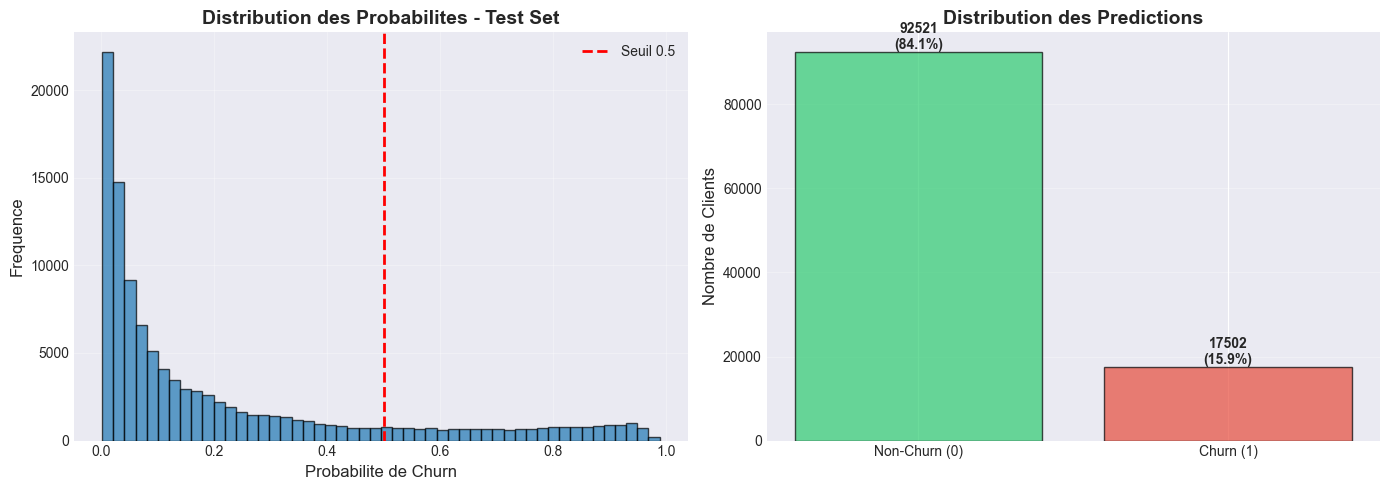

In [21]:
print("="*60)
print("GENERATION DU FICHIER DE SOUMISSION")
print("="*60)

# Creer un DataFrame avec les predictions
submission_df = pd.DataFrame({
    'prediction': y_test_pred,
    'probability': y_test_proba
})

# Ajouter l'ID si disponible
test_raw = pd.read_csv(base_path / 'data' / 'raw' / 'test.csv')
if 'id' in test_raw.columns:
    submission_df.insert(0, 'id', test_raw['id'])
elif 'CustomerId' in test_raw.columns:
    submission_df.insert(0, 'id', test_raw['CustomerId'])

# Sauvegarder
submission_path = base_path / 'data' / 'processed' / 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\nFichier de soumission cree: {submission_path}")
print(f"Nombre de lignes: {len(submission_df)}")
print(f"\nApercu:")
display(submission_df.head(10))

# %%
# Statistiques des predictions
print("\n--- STATISTIQUES DES PREDICTIONS ---")
print(f"\nPredictions Churn (1): {(submission_df['prediction'] == 1).sum()} ({(submission_df['prediction'] == 1).sum()/len(submission_df)*100:.2f}%)")
print(f"Predictions Non-Churn (0): {(submission_df['prediction'] == 0).sum()} ({(submission_df['prediction'] == 0).sum()/len(submission_df)*100:.2f}%)")

print(f"\nProbabilites:")
print(f"  Minimum: {submission_df['probability'].min():.4f}")
print(f"  Maximum: {submission_df['probability'].max():.4f}")
print(f"  Moyenne: {submission_df['probability'].mean():.4f}")
print(f"  Mediane: {submission_df['probability'].median():.4f}")

# %%
# Distribution des probabilites
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(submission_df['probability'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Probabilite de Churn', fontsize=12)
ax1.set_ylabel('Frequence', fontsize=12)
ax1.set_title('Distribution des Probabilites - Test Set', fontsize=14, fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Seuil 0.5')
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = axes[1]
pred_counts = submission_df['prediction'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = ax2.bar(['Non-Churn (0)', 'Churn (1)'], pred_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Nombre de Clients', fontsize=12)
ax2.set_title('Distribution des Predictions', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, pred_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({count/len(submission_df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## RECOMMANDATIONS BUSINESS

In [23]:
print("="*80)
print("RECOMMANDATIONS BUSINESS")
print("="*80)

if y_test is not None:
    print(f"""
PERFORMANCE DU MODELE:
  - ROC-AUC Test: {test_roc_auc:.4f}
  - F1-Score Test: {test_f1:.4f}
  - Recall Test: {test_recall:.4f}
  - Precision Test: {test_precision:.4f}

INTERPRETATION:
  - Le modele detecte {test_recall*100:.1f}% des clients qui vont partir
  - {test_precision*100:.1f}% des alertes sont correctes
  - Sur 100 alertes, {int(test_precision*100)} sont justifiees

ANALYSE DES ERREURS:
  - False Negatives: {fn} clients partis non detectes
  - False Positives: {fp} fausses alertes
  
COUT ESTIMATIF (hypotheses):
  - Cout d'une action de retention: 100 EUR
  - Perte si client part: 500 EUR
  
  Avec le modele:
    - Clients detectes correctement: {tp}
    - Economie potentielle: {tp * 500} EUR
    - Cout des actions: {(tp + fp) * 100} EUR
    - Gain net: {(tp * 500) - ((tp + fp) * 100)} EUR
  
  Sans le modele (actions aleatoires):
    - Gain net: Negatif
""")

RECOMMANDATIONS BUSINESS


In [25]:
print("""
RECOMMANDATIONS OPERATIONNELLES:

1. SEGMENTATION DES CLIENTS:
   - Probabilite > 0.7: Action immediate (appel personnalise)
   - Probabilite 0.5-0.7: Email cible avec offre
   - Probabilite 0.3-0.5: Newsletter avec avantages
   - Probabilite < 0.3: Communication standard

2. ACTIONS DE RETENTION:
   - Offrir une reduction temporaire
   - Proposer des produits complementaires
   - Ameliorer le service client
   - Programme de fidelite renforce

3. MONITORING:
   - Recalculer les scores mensuellement
   - Suivre le taux de conversion des actions
   - Ajuster le seuil selon les resultats business
   - Reent rainer le modele trimestriellement

4. PROCHAINES AMELIORATIONS:
   - Integrer des donnees comportementales temps reel
   - Tester des modeles plus complexes (Deep Learning)
   - Ajouter des features d'interaction client
   - Implementer un systeme de scoring en temps reel
""")

print("="*80)
print("EVALUATION FINALE TERMINEE AVEC SUCCES!")
print("="*80)


RECOMMANDATIONS OPERATIONNELLES:

1. SEGMENTATION DES CLIENTS:
   - Probabilite > 0.7: Action immediate (appel personnalise)
   - Probabilite 0.5-0.7: Email cible avec offre
   - Probabilite 0.3-0.5: Newsletter avec avantages
   - Probabilite < 0.3: Communication standard

2. ACTIONS DE RETENTION:
   - Offrir une reduction temporaire
   - Proposer des produits complementaires
   - Ameliorer le service client
   - Programme de fidelite renforce

3. MONITORING:
   - Recalculer les scores mensuellement
   - Suivre le taux de conversion des actions
   - Ajuster le seuil selon les resultats business
   - Reent rainer le modele trimestriellement

4. PROCHAINES AMELIORATIONS:
   - Integrer des donnees comportementales temps reel
   - Tester des modeles plus complexes (Deep Learning)
   - Ajouter des features d'interaction client
   - Implementer un systeme de scoring en temps reel

EVALUATION FINALE TERMINEE AVEC SUCCES!
